<a href="https://colab.research.google.com/github/ElenaHrytsai/Belgian-Traffic-Dataset/blob/main/belgiumTSC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [25]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import zipfile
import imageio
from skimage.io import imread, imshow
from skimage import data
import random

Connect Google Drive to Colab and create a copy of train and test directories

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [3]:
!cp /content/gdrive/MyDrive/TrafficSigns/BelgiumTSC_Training.zip .

In [4]:
!cp /content/gdrive/MyDrive/TrafficSigns/BelgiumTSC_Testing.zip .

In [5]:
!ls

BelgiumTSC_Testing.zip	BelgiumTSC_Training.zip  drive	gdrive	sample_data


Create variables for train and test directories

In [6]:
train = zipfile.ZipFile('BelgiumTSC_Training.zip', 'r')
test = zipfile.ZipFile('BelgiumTSC_Testing.zip', 'r')
train.extractall()
test.extractall()

Both training and testing data directiries contines the subfolders, which are the 62 types of traffic signs that we’ll use for classification.  
We use **load_data** function for gathering all the subdirectories.  
- First, we need to initialize two lists, labels and images.
- Next, gather the paths of the subdirectories and the file names of the images that are stored in these subdirectories.
- After, we can collect the data in the two lists with the help of the **append()** function.

In [7]:
def load_data(data_directory):
    directories = [d for d in os.listdir(data_directory)
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f)
                      for f in os.listdir(label_directory)
                      if f.endswith(".ppm")]
        for f in file_names:
            images.append(imageio.imread(f))
            labels.append(int(d))
    return images, labels

ROOT_PATH = "/content/"
train_data_directory = os.path.join(ROOT_PATH, "Training")
test_data_directory = os.path.join(ROOT_PATH, "Testing")

images, labels = load_data(train_data_directory)

<ipython-input-7-800e5a6bd46c>:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f))


Let's do some simple data analysis on train dataset.

In [8]:
num_labels = []
for i in range (len(set(labels))):
  num_labels.append(labels.count(i))
print('number of examples:', len(images))
print('number of labels:',len(num_labels),', from', min(num_labels),'to', max(num_labels))
print(num_labels)

number of examples: 4575
number of labels: 62 , from 6 to 375
[15, 110, 13, 15, 15, 11, 18, 157, 27, 18, 21, 7, 18, 90, 43, 9, 9, 79, 81, 231, 42, 43, 375, 15, 48, 42, 6, 18, 125, 33, 37, 63, 316, 12, 46, 60, 18, 98, 285, 196, 242, 148, 35, 30, 48, 74, 44, 147, 11, 12, 15, 27, 27, 199, 118, 12, 95, 78, 15, 42, 9, 282]


Now we see that our train dataset contains a 4575 traffic sigh examples (variable **images**). All the examples separated into 62 types (variable **labels**) not in equal proportion, so we have from 6 to 375 examples of each traffic sign type.

For clarity let's visualize the distribution of example's type using **matplotlib**

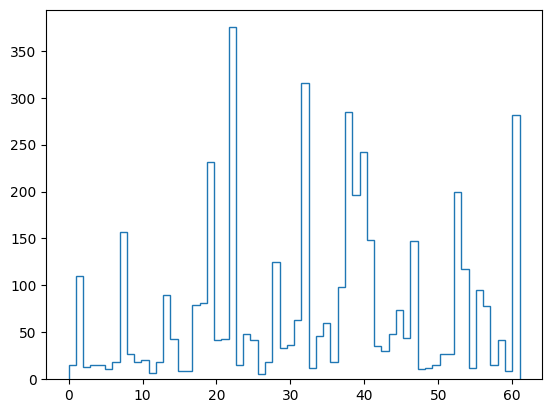

In [9]:
import matplotlib.pyplot as plt
plt.hist(labels, 62, histtype = 'step')
plt.show()

For further exploring the data we are working with, we will randomly select the 5 traffic signs and visualizate them by creating a subplot.

In [10]:
traffic_5 = [5, 450, 1500, 2800, 4000]

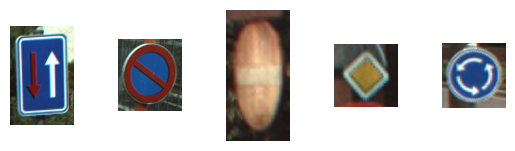

In [11]:
for i in range(len(traffic_5)):
  plt.subplot(1, 5, i+1)
  plt.axis('off')
  plt.imshow(images[traffic_5[i]])
  plt.subplots_adjust(wspace = 0.7)
plt.show()

One important observation that we need to take into account before using the neural network, that the traffic signs images have different shape.

We can confirm this by using the code below.

In [12]:
for i in range(len(traffic_5)):
  print('shape: {0}, min {1}, max {2}'.format(images[traffic_5[i]].shape, images[traffic_5[i]].min(), images[traffic_5[i]].max()))
  i+1

shape: (175, 112, 3), min 2, max 255
shape: (154, 136, 3), min 9, max 255
shape: (97, 47, 3), min 11, max 255
shape: (51, 51, 3), min 13, max 212
shape: (69, 68, 3), min 14, max 255


Let's plot the short review of all 62 unique types with one images. We can also add a title with how much examples of each type do we have.

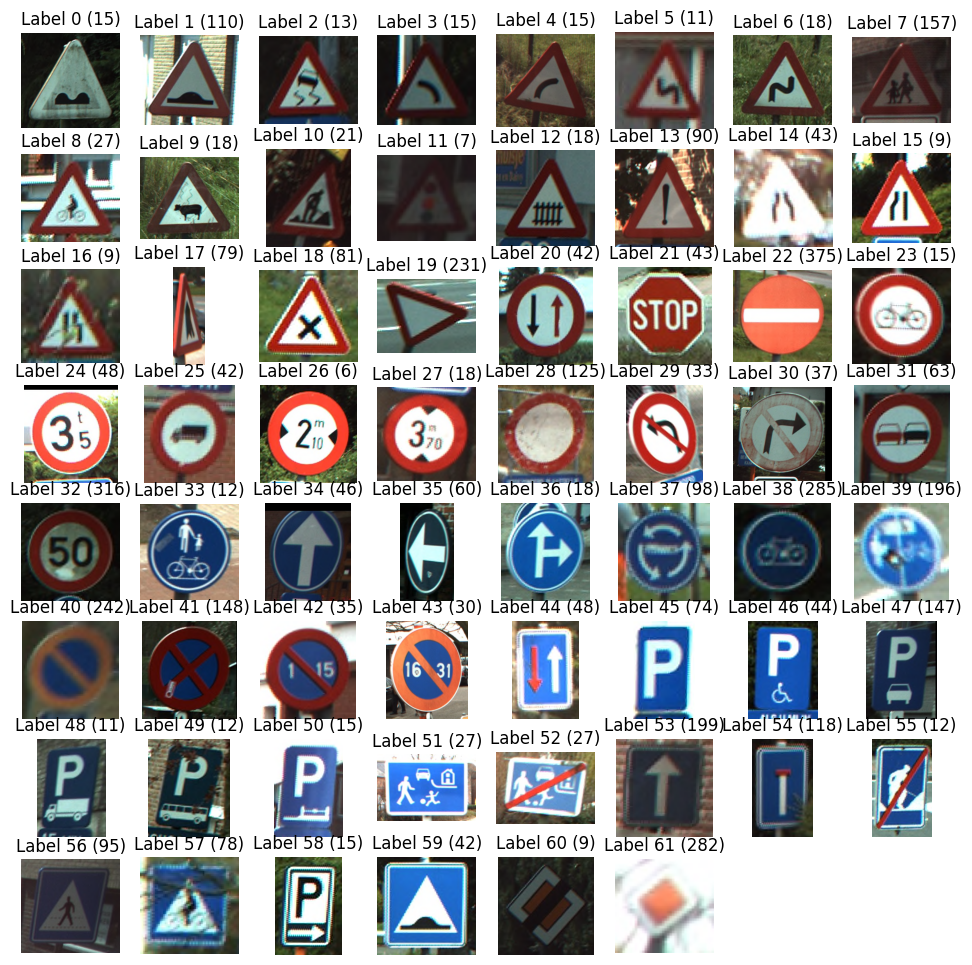

In [13]:
unique_l = set(labels)
plt.figure(figsize=(12, 12))
i = 1
for l in unique_l:
  image = images[labels.index(l)]
  plt.subplot(8, 8, i)
  plt.axis('off')
  plt.title('Label {0} ({1})'.format(l, labels.count(l)))
  i+=1
  plt.imshow(image)
plt.show()

We will handle the difference in image's size by using transform module from **Skimage** labriary. Let's resize each image to 28 by 28 pixels.

In [14]:
from skimage import transform

In [15]:
images28 = [transform.resize(image, (28, 28, 3)) for image in images]
images28 = np.array(images28)

In [16]:
for i in range (len(traffic_5)):
  print('Shape: {0}, min {1}, max {2}'.format(images28[traffic_5[i]].shape, images28[traffic_5[i]].min(), images28[traffic_5[i]].max()))

Shape: (28, 28, 3), min 0.06878764695615376, max 0.9971312309446669
Shape: (28, 28, 3), min 0.0905981467010592, max 0.7378844889649587
Shape: (28, 28, 3), min 0.07031867296914152, max 0.9845444778252919
Shape: (28, 28, 3), min 0.062386966679481626, max 0.79537488494718
Shape: (28, 28, 3), min 0.06385069182018988, max 0.9863634136914312


As the color of the pictures matters less for a classification question, we will convert the images to grayscale using **rgb2gray**

In [17]:
from skimage.color import rgb2gray

In [18]:
images28 = rgb2gray(images28)

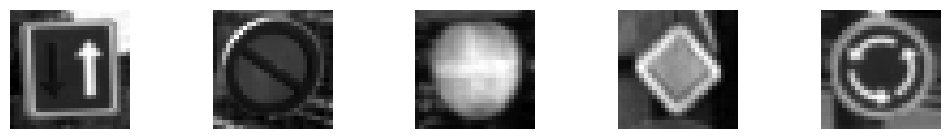

In [157]:
plt.figure(figsize=(12, 12))
for i in range(len(traffic_5)):
  plt.subplot(1, 5, i+1)
  plt.axis('off')
  plt.imshow(images28[traffic_5[i]], cmap='gray')
  plt.subplots_adjust(wspace = 0.7)
plt.show()

In [20]:
images28.shape

(4575, 28, 28)

Next, we build up and train the neural network using **Keras sequential** model

In [21]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(62)
])

In [22]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [26]:
model.fit(images28, np.array(labels), epochs=10)

Epoch 1/10
143/143 [==============================] - 0s 2ms/step - loss: 0.4590 - accuracy: 0.8953
Epoch 2/10
143/143 [==============================] - 0s 2ms/step - loss: 0.4144 - accuracy: 0.9060
Epoch 3/10
143/143 [==============================] - 0s 2ms/step - loss: 0.3908 - accuracy: 0.9027
Epoch 4/10
143/143 [==============================] - 0s 2ms/step - loss: 0.3540 - accuracy: 0.9172
Epoch 5/10
143/143 [==============================] - 0s 2ms/step - loss: 0.3389 - accuracy: 0.9178
Epoch 6/10
143/143 [==============================] - 0s 2ms/step - loss: 0.3080 - accuracy: 0.9296
Epoch 7/10
143/143 [==============================] - 0s 2ms/step - loss: 0.2999 - accuracy: 0.9259
Epoch 8/10
143/143 [==============================] - 0s 2ms/step - loss: 0.2710 - accuracy: 0.9333
Epoch 9/10
143/143 [==============================] - 0s 2ms/step - loss: 0.2568 - accuracy: 0.9381
Epoch 10/10
143/143 [==============================] - 0s 2ms/step - loss: 0.2431 - accuracy: 0.9403

In [27]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 62)                7998      
                                                                 
Total params: 108478 (423.74 KB)
Trainable params: 108478 (423.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Let's try to check on how the model predicts the class for any random image

In [28]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [29]:
predictions = probability_model.predict(images28)

143/143 [==============================] - 0s 1ms/step


In [162]:
test_label = random.randint(0, len(images28))
print(test_label, labels[test_label])

1457 22


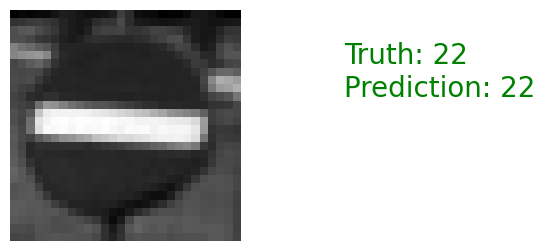

In [163]:
plt.figure(figsize=(3, 3))
truth = labels[test_label]
predict = np.argmax(predictions[test_label])
plt.axis("off")
color='green' if truth==predict else 'red'
plt.text(40, 10, 'Truth: {0}\nPrediction: {1}'.format(truth, predict), fontsize=20, color=color)
plt.imshow(images28[test_label], cmap='gray')
plt.show()

Let's predict the class for more test images

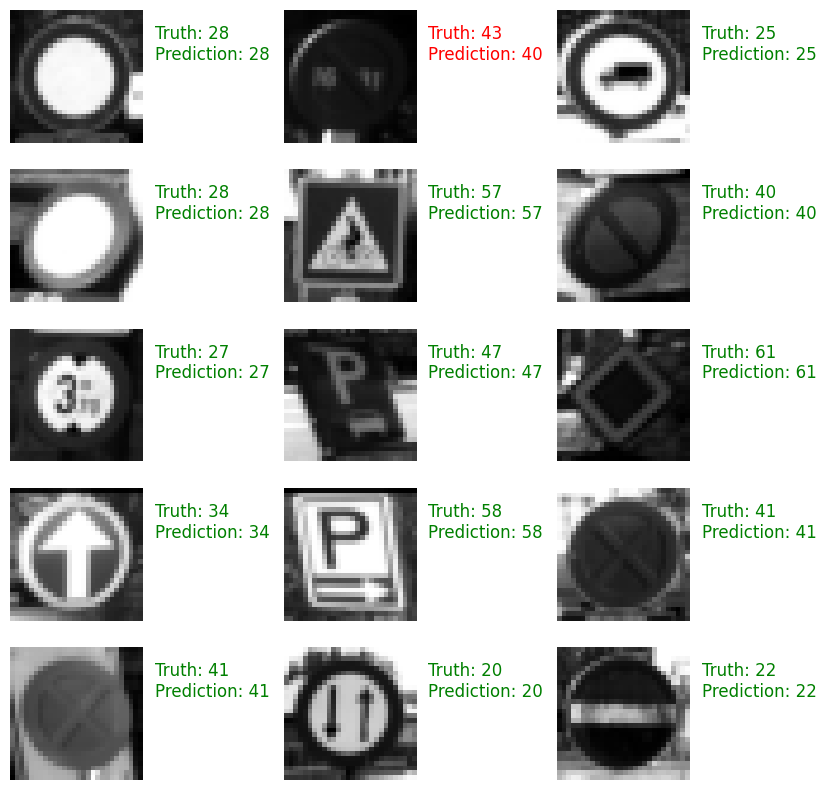

In [179]:
test_i = random.sample(range(len(images28)), 15)
plt.figure(figsize=(10, 10))
for i in range(len(test_i)):
  truth = labels[test_i[i]]
  predict = np.argmax(predictions[test_i[i]])
  plt.subplot(5, 3, i+1)
  plt.axis("off")
  color='green' if truth==predict else 'red'
  plt.text(30, 10, 'Truth: {0}\nPrediction: {1}'.format(truth, predict), fontsize=12, color=color)
  plt.imshow(images28[test_i[i]], cmap='gray')
plt.show()

Finally, let's make the accuracy of the model more visible.

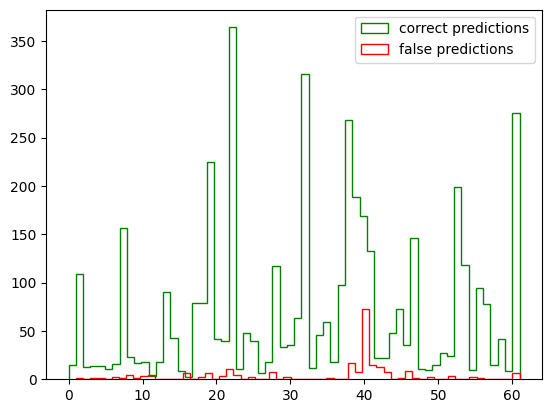

In [205]:
false_predict = []
correct_predict = []
for i in range(len(predictions)):
  truth = labels[i]
  predict = np.argmax(predictions[i])
  if truth != predict:
    false_predict.append(labels[i])
  else: correct_predict.append(labels[i])
plt.subplot()
plt.hist(correct_predict, 62, histtype = 'step', color='green', label='correct predictions')
plt.hist(false_predict, 62, histtype = 'step', color='red', label='false predictions')
plt.legend()
plt.show()